<a href="https://colab.research.google.com/github/fhfmendes04/face_recognition_4models/blob/main/CNN_Classificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
from PIL import Image
from skimage import data, exposure
from skimage.feature import hog,local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#from Models import ANN, Multinomial_LogReg

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [2]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(random_state=42)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [3]:
X = dataset.images
y = dataset.target

In [4]:
from collections import Counter 
d = Counter(y)
print("Quantidade de pessoas:",len(d))
print(d)

Quantidade de pessoas: 40
Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10, 20: 10, 21: 10, 22: 10, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10, 38: 10, 39: 10})


# Entrada(imagem) e saída(one-hot) da CNN.

In [5]:
def lbp_features(X): 
    METHOD = 'uniform'
    radius = 1
    n_points = 10
    fd_list = []
    for row in X:
        lbp_image = local_binary_pattern(row, n_points, radius, METHOD)
        fd_list.append(lbp_image)
    
    return np.array(fd_list)

In [6]:
image_lbp= lbp_features(X)
print(image_lbp.shape)

(400, 64, 64)


In [7]:
def hog_features(X): #====>>>>>>Usei segunda saída da funcção que é uma imagem e não a primeira saída da função.
    fd_list = []
    for row in X:
        _, hog_image = hog(row, orientations=2, pixels_per_cell=(4, 4), cells_per_block=(4, 4), visualize=True)
        fd_list.append(hog_image)
    
    return np.array(fd_list)

In [8]:
image_hog = hog_features(X)
print(image_hog.shape)

(400, 64, 64)


In [9]:
print("HOG:",image_hog.max(), image_hog.min())
print("LBP:", image_lbp.max(), image_lbp.min())

# Não precisei normalizar.

HOG: 0.41988638043403625 0.0
LBP: 11.0 0.0


In [43]:
# transformar categorias em one-hot-encoding: Saída
saida = y.max()+1
print("Quantidade de pessoas:",saida)
target = keras.utils.to_categorical(y, saida)

Quantidade de pessoas: 40


# CNN


## LBP

In [13]:
x_train, x_test, y_train, y_test = train_test_split(image_lbp, target, test_size=0.30, random_state=42,stratify=target)

In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((280, 64, 64), (280, 40), (120, 64, 64), (120, 40))

In [15]:
# obtendo informações das imagens (resolucao) e dos rótulos (número de classes)
# não usar no HOG
img_lin, img_col = x_train.shape[1], x_train.shape[2]
num_classes = len(np.unique(y_train))
print(x_train.shape)

(280, 64, 64)


In [16]:
# verifica imagens da base de dados tem 3 canais (RGB) ou apenas 1 (escala de cinza)

if (len(x_train.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train.shape[3]

# re-formata o array de forma a encontrar o formato da entrada (input_shape)
# se a dimensão dos canais vem primeiro ou após a imagem
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_lin, img_col)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train = x_train.reshape(x_train.shape[0], img_lin, img_col, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

print("Shape: ", input_shape)

Shape:  (64, 64, 1)


In [36]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', use_bias=True, padding='same', input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', use_bias=True, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', use_bias=True, strides=(4,4), padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', use_bias=True, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', use_bias=True, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', use_bias=True, strides=(2,2), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(216, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(saida, activation='softmax'))

model.summary()

# Para diminuir o overfitting aumenta a porcentagem do dropout

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 64, 64, 256)       2560      
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 128)       295040    
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 flatten_4 (Flatten)         (None, 16384)            

In [37]:
# as sementes ajudam a ter resultados reproduzíveis
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
               metrics=['categorical_accuracy'])

# vamos usar o mesmo número de épocas e batchsize para ambos
batch_size = 100
epochs = 1000

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75) # Parada

hist_model = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_split=0.1,
                    use_multiprocessing= True,
                    callbacks=[callback],
                    epochs=epochs, 
                    verbose=1)

Epoch 1/1000
3/3 [==============================] - 1s 220ms/step - loss: 3.9985 - categorical_accuracy: 0.0159 - val_loss: 3.6991 - val_categorical_accuracy: 0.0000e+00
Epoch 2/1000
3/3 [==============================] - 0s 125ms/step - loss: 3.6899 - categorical_accuracy: 0.0278 - val_loss: 3.7264 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 0s 125ms/step - loss: 3.6930 - categorical_accuracy: 0.0238 - val_loss: 3.7206 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1000
3/3 [==============================] - 0s 126ms/step - loss: 3.6857 - categorical_accuracy: 0.0357 - val_loss: 3.7828 - val_categorical_accuracy: 0.0000e+00
Epoch 5/1000
3/3 [==============================] - 0s 125ms/step - loss: 3.6948 - categorical_accuracy: 0.0159 - val_loss: 3.7229 - val_categorical_accuracy: 0.0000e+00
Epoch 6/1000
3/3 [==============================] - 0s 124ms/step - loss: 3.6870 - categorical_accuracy: 0.0198 - val_loss: 3.7046 - val_categorical_a

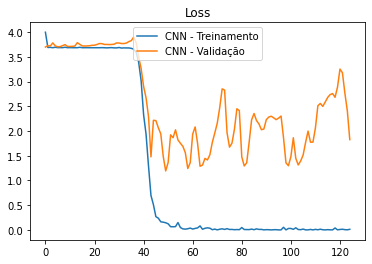

In [40]:
plt.plot(hist_model.history['loss'])
plt.plot(hist_model.history['val_loss'])
plt.title('Loss')
plt.legend(["CNN - Treinamento", "CNN - Validação"], loc="upper center")

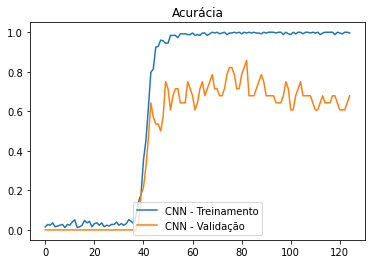

In [41]:
plt.plot(hist_model.history['categorical_accuracy'])
plt.plot(hist_model.history['val_categorical_accuracy'])
plt.title('Acurácia')
plt.legend(["CNN - Treinamento", "CNN - Validação"], loc="lower center")

In [42]:
print("Treinamento:")
score_tr = model.evaluate(x_train, y_train, verbose = 1, batch_size=batch_size)
print("Teste:")
score_Te = model.evaluate(x_test, y_test, verbose = 1, batch_size=batch_size)

Treinamento:
3/3 [==============================] - 0s 57ms/step - loss: 0.1827 - categorical_accuracy: 0.9679
Teste:
2/2 [==============================] - 0s 16ms/step - loss: 1.2427 - categorical_accuracy: 0.8167


## HOG

In [44]:
x_train, x_test, y_train, y_test = train_test_split(image_hog, target, test_size=0.30, random_state=42,stratify=target)

In [45]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((280, 64, 64), (280, 40), (120, 64, 64), (120, 40))

In [46]:
# obtendo informações das imagens (resolucao) e dos rótulos (número de classes)
# não usar no HOG
img_lin, img_col = x_train.shape[1], x_train.shape[2]
num_classes = len(np.unique(y_train))
print(x_train.shape)

(280, 64, 64)


In [47]:
# verifica imagens da base de dados tem 3 canais (RGB) ou apenas 1 (escala de cinza)

if (len(x_train.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train.shape[3]

# re-formata o array de forma a encontrar o formato da entrada (input_shape)
# se a dimensão dos canais vem primeiro ou após a imagem
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_lin, img_col)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train = x_train.reshape(x_train.shape[0], img_lin, img_col, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

print("Shape: ", input_shape)

Shape:  (64, 64, 1)


In [61]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', use_bias=True, padding='same', input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', use_bias=True, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', use_bias=True, strides=(4,4), padding='same'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', use_bias=True, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', use_bias=True, padding='same'))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', use_bias=True, strides=(2,2), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(216, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(saida, activation='softmax'))

model.summary()

# Quando aumentei o Dropout não convergiu.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 64, 64, 256)       2560      
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 128)       295040    
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_52 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 conv2d_54 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 flatten_8 (Flatten)         (None, 16384)            

In [62]:
# as sementes ajudam a ter resultados reproduzíveis
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
               metrics=['categorical_accuracy'])

# vamos usar o mesmo número de épocas e batchsize para ambos
batch_size = 100
epochs = 1000

In [63]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75) # Parada

hist_model = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_split=0.1,
                    use_multiprocessing= True,
                    callbacks=[callback],
                    epochs=epochs, 
                    verbose=1)

Epoch 1/1000
3/3 [==============================] - 1s 209ms/step - loss: 3.6901 - categorical_accuracy: 0.0119 - val_loss: 3.6950 - val_categorical_accuracy: 0.0000e+00
Epoch 2/1000
3/3 [==============================] - 0s 128ms/step - loss: 3.6889 - categorical_accuracy: 0.0357 - val_loss: 3.7018 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 0s 126ms/step - loss: 3.6880 - categorical_accuracy: 0.0238 - val_loss: 3.7148 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1000
3/3 [==============================] - 0s 126ms/step - loss: 3.6878 - categorical_accuracy: 0.0317 - val_loss: 3.7341 - val_categorical_accuracy: 0.0000e+00
Epoch 5/1000
3/3 [==============================] - 0s 125ms/step - loss: 3.6865 - categorical_accuracy: 0.0079 - val_loss: 3.7276 - val_categorical_accuracy: 0.0000e+00
Epoch 6/1000
3/3 [==============================] - 0s 128ms/step - loss: 3.6870 - categorical_accuracy: 0.0040 - val_loss: 3.7318 - val_categorical_a

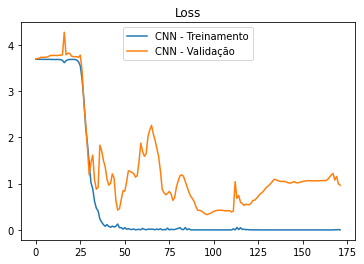

In [64]:
plt.plot(hist_model.history['loss'])
plt.plot(hist_model.history['val_loss'])
plt.title('Loss')
plt.legend(["CNN - Treinamento", "CNN - Validação"], loc="upper center")

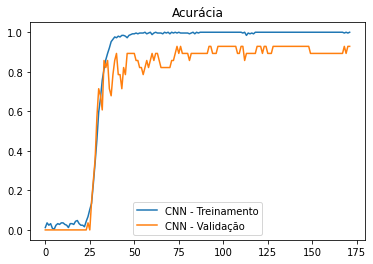

In [65]:
plt.plot(hist_model.history['categorical_accuracy'])
plt.plot(hist_model.history['val_categorical_accuracy'])
plt.title('Acurácia')
plt.legend(["CNN - Treinamento", "CNN - Validação"], loc="lower center")

In [66]:
print("Treinamento:")
score_tr = model.evaluate(x_train, y_train, verbose = 1, batch_size=batch_size)
print("Teste:")
score_Te = model.evaluate(x_test, y_test, verbose = 1, batch_size=batch_size)

Treinamento:
3/3 [==============================] - 0s 63ms/step - loss: 0.0969 - categorical_accuracy: 0.9929
Teste:
2/2 [==============================] - 0s 16ms/step - loss: 1.1291 - categorical_accuracy: 0.8833
